In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training BKK with *minimal_SARIMAX*

In [7]:
import sys
sys.path.append('../')

In [8]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [35]:
train_set = pd.read_csv('6Hsampled_data_set/SURAT/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/SURAT/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/SURAT/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [11]:
order = (2, 0, 0)
seasonal_order = (0, 1, 0, 1461)

exog_order = {}
exog_order['Temp'] = (1, 1, 0)
exog_order['WindSpeed'] = (1, 1, 0)
exog_order['WindDirSin'] = (1, 0, 1)
exog_order['WindDirCos'] = (1, 0, 1)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (0, 1, 1, 1461)
exog_seasonal_order['WindSpeed'] = (0, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 1, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [37]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [36]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.9995, lr_decay_iter=0.75,
                                          step=12, n_iter=1, learn=True, verbose=1)

#### Surathani

In [39]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([1e-6, 1e-7, 1e-7, 1e-7, 1e-7]), lr_decay=0.9995, lr_decay_iter=0.75,
                                  step=12, n_iter=1, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

  5%|▌         | 220/4383 [00:30<12:24,  5.59it/s]

In [ ]:
model.params

In [17]:
with open('../model_save/model_surat.model',"wb") as f:
    pickle.dump(model, f)

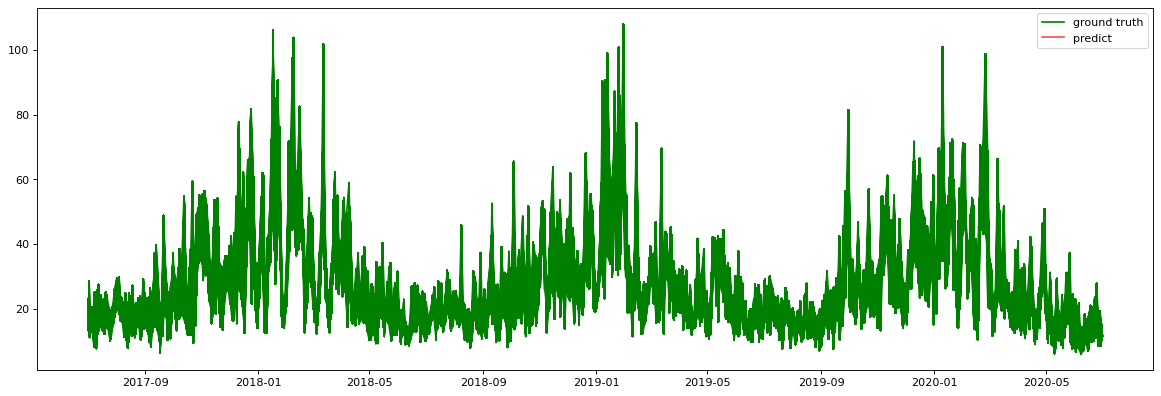

In [82]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [67]:
Result_test = model.predict_step(valid_set[['PM25']],
                                               test_set[['PM25']], 
                                               val_X_exog=valid_set[exog_columns],
                                               y_exog=test_set[exog_columns], 
                                               model_exog=model_exog,
                                               lr=np.array([1e-7, 1e-7, 1e-7, 5e-9]), lr_decay=0.9998975,
                                               step=12, n_iter=1, learn=False)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████████████████████████████████████████████████████████████████████████| 2779/2779 [06:09<00:00,  7.51it/s]


In [ ]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [ ]:
((Error_save**2).mean())**(1/2)

In [18]:
test_pred_sav.to_csv('answer_dataset/pred_and_actual/y_pred_sav_SURAT.csv')